# CSC421 Fall 2023 Assignment 3 
### Author: George Tzanetakis 

This notebook is based on the topics covered in **Chapter 12 - Quantifying Uncertainty**, **Chapter 13 Probabilistic Reasoning** , and **Chapter 14 Probabistic Reasoning over time** from the book *Artificial Intelligence: A Modern Approach.*  You are welcome and actually it can be educational to look at the code at the aima-code repository as well as other code resources you can find on the web. However, make sure you understand any code that you incoporate. 

The assignment structure is as follows - each item is worth 1 point: 

1. Non-transitive dice war (Basic)   
2. Specifying a Bayesian Network (Basic) 
3. Inference on a Bayesian Netowrk (Expected) 
4. Specifying a Hidden Markov Model (Basic) 
5. Inference and estimation using HMM (Expected) 
6. Text Categorization setup (Basic) 
7. Text Classification (Expected) 
8. Text Classification evaluation (Expected) 
9. Maximum likelihood, MAP, and Baysian Learning for discrete/continuous model 
10. 2D HMM with Gaussian Mixture Model



# Question 1 (Basic)  Non-transitive dice war 

In this question we will explore generating samples of discrete random variables and the fascinating concept of non-transitive dice. A dice war is a game in which two dice with 
different probability distributions are randomly sampled, the corresponding 
samples are comprared, and the one with the highest number is counted as a "win". If a dice $A$ wins on average more than half of the time against another dice $B$ we say that dice $A$ beats dice $B$. 

For example let's consider a standard dice $A$ with probability distribution: $P(A) = <\frac{1}{6}, \frac{1}{6}, \frac{1}{6}, \frac{1}{6}, \frac{1}{6}, \frac{1}{6}>$ and a dice $B$ that has 3 faces with the number $3$ and three faces with the number $4$ so that $P(B) = <0, 0, 0, \frac{3}{6}, \frac{3}{6}, 0>$.  

In the cell below code is provided for defining a random variables by providing an array of values and an array of corresponding probabilities. Complete the function $dice_war$ based on the code and documentation provided in the cell bellow. Show that the dice $B$ described above wins on average the war against dice $A$. 

Now consider the following three dice/random variables $Red, Green, Blue$. They all have six faces 
but different values. The corresponding values are: 

1. $[2,2,4,4,9,9]$ for $Red$
2. $[1,1,6,6,8,8]$ for $Green$ 
3. $[3,3,5,5,7,7]$ for $Blue$

Using the dice war function you wrote show the counter-intuitive result that the $Red$ die beats the $Green$ die, the $Green$ die beats the $Blue$ die, but the $Blue$ die beats the $Red$ die. 




In [1]:
# Modify this code as needed 

import numpy as np
from scipy import stats

class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution
        if all(type(item) is (np.int32 or np.int64) for item in values):
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'):
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples

    def get_name(self):
        return self.name
    
values = np.array([1,2,3,4,5,6])
probabilities_A = np.array([1/6., 1/6., 1/6., 1/6., 1/6., 1/6.])
probabilities_B = np.array([0.0, 0.0, 0/6., 3/6., 3/6., 0/6.])

dieA = Random_Variable('DieA', values, probabilities_A)
dieB = Random_Variable('DieB', values, probabilities_B)


"""Gets and prints the spreadsheet's header columns

Parameters
----------
file_loc : str
    The file location of the spreadsheet
print_cols : bool, optional
    A flag used to print the columns to the console (default is False)

Returns
-------
list
    a list of strings representing the header columns
"""
print()

def dice_war(A,B, num_samples = 1000, output=True):
    # your code goes here 
    
    samplesA = A.sample(num_samples)
    samplesB = B.sample(num_samples)
    prob = 0

    for i in range(0, num_samples):
        if samplesA[i] > samplesB[i]:
            prob += 1/num_samples
        

    res = prob > 0.5 
    
    if output: 
        if res:
            print('{} beats {} with probability {:.2f}'.format(A.get_name(),
                                                           B.get_name(),
                                                           prob))
        else:
            print('{} beats {} with probability {:.2f}'.format(B.get_name(),
                                                               A.get_name(),
                                                               1.0-prob))
    return (res, prob)
        

dice_war(dieA, dieB, 10000)


# Add code here to show the non-transitive nature of Red, Green, Blue dice 
red = Random_Variable('red_die', np.array([2,2,4,4,9,9]), probabilities_A)
green = Random_Variable('green_die', np.array([1,1,6,6,8,8]), probabilities_A)
blue = Random_Variable('blue_die', np.array([3,3,5,5,7,7]), probabilities_A)


dice_war(red, green)
dice_war(green, blue)
dice_war(blue, red)




DieB beats DieA with probability 0.75
red_die beats green_die with probability 0.55
green_die beats blue_die with probability 0.54
blue_die beats red_die with probability 0.54


(True, 0.5380000000000004)

# Question 2 (Basic)  - Specifying a Bayesian Network 

<img src="dispnea.png">

Using the convetions for DBNs used in probability.ipynb (from the AIMA authors) encode the diapnea network shown above. Once you have constructed the Bayesian network display the cpt for the Lung Cancer Node (using the API provided not just showing the numbers).

The cell below contains the code that defines BayesNodes and BayesNetworks and the following cell 
shows an example of defining the Burglary network and performing a query using direct enumeration and rejection sampling. 

In [12]:
import numpy as np 
import random 

def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

def event_values(event, variables):                                                                      
    """Return a tuple of the values of variables in event.                                               
    >>> event_values ({'A': 10, 'B': 9, 'C': 8}, ['C', 'A'])                                             
    (8, 10)                                                                                              
    >>> event_values ((1, 2), ['C', 'A'])                                                                
    (1, 2)                                                                                               
    """                                                                                                  
    if isinstance(event, tuple) and len(event) == len(variables):                                        
        return event                                                                                     
    else:                                                                                                
        return tuple([event[var] for var in variables])                                                  
                      
def probability(p):                                                                                      
    """Return true with probability p."""                                                                
    return p > random.uniform(0.0, 1.0)  
        
class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    >>> P = ProbDist('Flip'); P['H'], P['T'] = 0.25, 0.75; P['H']
    0.25
    >>> P = ProbDist('X', {'lo': 125, 'med': 375, 'hi': 500})
    >>> P['lo'], P['med'], P['hi']
    (0.125, 0.375, 0.5)
    """

    def __init__(self, var_name='?', freq=None):
        """If freq is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.var_name = var_name
        self.values = []
        if freq:
            for (v, p) in freq.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p) for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.var_name)


class BayesNode:
    """A conditional probability distribution for a boolean variable,
    P(X | parents). Part of a BayesNet."""

    def __init__(self, X, parents, cpt):
        """X is a variable name, and parents a sequence of variable
        names or a space-separated string. cpt, the conditional
        probability table, takes one of these forms:

        * A number, the unconditional probability P(X=true). You can
          use this form when there are no parents.

        * A dict {v: p, ...}, the conditional probability distribution
          P(X=true | parent=v) = p. When there's just one parent.

        * A dict {(v1, v2, ...): p, ...}, the distribution P(X=true |
          parent1=v1, parent2=v2, ...) = p. Each key must have as many
          values as there are parents. You can use this form always;
          the first two are just conveniences.

        In all cases the probability of X being false is left implicit,
        since it follows from P(X=true).

        >>> X = BayesNode('X', '', 0.2)
        >>> Y = BayesNode('Y', 'P', {T: 0.2, F: 0.7})
        >>> Z = BayesNode('Z', 'P Q',
        ...    {(T, T): 0.2, (T, F): 0.3, (F, T): 0.5, (F, F): 0.7})
        """
        if isinstance(parents, str):
            parents = parents.split()

        # We store the table always in the third form above.
        if isinstance(cpt, (float, int)):  # no parents, 0-tuple
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # one parent, 1-tuple
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return the conditional probability
        P(X=value | parents=parent_values), where parent_values
        are the values of parents in event. (event must assign each
        parent a value.)
        >>> bn = BayesNode('X', 'Burglary', {T: 0.2, F: 0.625})
        >>> bn.p(False, {'Burglary': False, 'Earthquake': True})
        0.375"""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue

    def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))
    
    
class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        """Nodes must be ordered with parents before children."""
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        """Add a node to the net. Its parents must already be in the
        net, and its variable must not."""
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        """Return the node for the variable named var.
        >>> burglary.variable_node('Burglary').variable
        'Burglary'"""
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def variable_values(self, var):
        """Return the domain of var."""
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)
    
    
def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))

def enumeration_ask(X, e, bn):
    """
    [Figure 14.9]
    Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn.
    >>> enumeration_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()

def consistent_with(event, evidence):
    """Is event consistent with the given evidence?"""
    return all(evidence.get(k, v) == v for k, v in event.items())

def prior_sample(bn):
    """
    [Figure 14.13]
    Randomly sample from bn's full joint distribution.
    The result is a {variable: value} dict.
    """
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

def rejection_sampling(X, e, bn, N=10000):
    """
    [Figure 14.14]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn, using N samples.
    Raises a ZeroDivisionError if all the N samples are rejected,
    i.e., inconsistent with e.
    >>> random.seed(47)
    >>> rejection_sampling('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.7, True: 0.3'
    """
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.14]
    for j in range(N):
        sample = prior_sample(bn)  # boldface x in [Figure 14.14]
        if consistent_with(sample, e):
            counts[sample[X]] += 1
    return ProbDist(X, counts)

def weighted_sample(bn, e):
    """
    Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence.
    """
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w

def likelihood_weighting(X, e, bn, N=10000):
    """
    [Figure 14.15]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)


In [2]:
from collections import Counter 
bn = BayesNode('X', 'Burglary', {True: 0.2, False: 0.625})

bn.p(True, {'Burglary': False, 'Earthquake': True})

samples = [] 
for i in range(0,10000): 
    samples.append(bn.sample({'Burglary': True, 'Earthquake': True}))
print(Counter(samples))
    

Counter({False: 7963, True: 2037})


In [3]:
burglary = BayesNet([
        ('Burglary', '', 0.001),
        ('Earthquake', '', 0.002),
        ('Alarm', ['Burglary', 'Earthquake'],
         {(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001}),
        ('JohnCalls', 'Alarm', {True: 0.90, False: 0.05}),
        ('MaryCalls', 'Alarm', {True: 0.70, False: 0.01})
    ])
print(burglary.variable_node('Alarm').cpt)
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
print(ans_dist[True],ans_dist[False])
print(rejection_sampling('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary, 10000).show_approx())


{(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001}
0.2841718353643929 0.7158281646356071
False: 0.731, True: 0.269


In [17]:
# YOUR CODE GOES HERE 
diapnea = BayesNet([('A', '', 0.01),
                    ('S', '', 0.5), 
                    ('T', 'A', {True: 0.05, False: 0.01}),
                    ('L', 'S', {True: 0.1, False: 0.01}),
                    ('B', 'S', {True: 0.6, False: 0.3}),
                    ('E', ['T', 'L'], {(True, True): 1, (True, False): 1, (False, True): 1, (False, False): 0}),
                    ('X', 'E', {True: 0.98, False: 0.05}),
                    ('D', ['E', 'B'], {(True, True): 0.9, (True, False): 0.7, (False, True): 0.8, (False, False): 0.1}),
                    ])

print(diapnea.variable_node('L').cpt)



{(True,): 0.1, (False,): 0.01}


# Question 3 (Expected) - Querying the Baysian Network 

Answer using exact inference with enumeration the following query: given that a patient has been in Asia and has a positive xray, what is the likelihood of having dispnea using enumeration ask 
Write code for this same query using enumeration_ask. Answer using approximate inference the same query using both rejection sampling and likelihood weighting.

In [34]:
# YOUR CODE GOES HERE 
print("Using Exact Inference through Enumeration:")
diap_dist = enumeration_ask('D', {'X': True, 'A': True}, diapnea)
print(diap_dist[True],diap_dist[False], "\n")

print("Using Rejection Sampling:")
print(rejection_sampling('D', {'X': True, 'A': True}, diapnea, 10000).show_approx(), "\n")

print("Using Likelihood Weighting:")
print(likelihood_weighting('D', {'X': True, 'A': True}, diapnea, 10000).show_approx(), "\n")

Using Exact Inference through Enumeration:
0.6811011940658546 0.3188988059341455 

Using Rejection Sampling:
False: 0.571, True: 0.429 

Using Likelihood Weighting:
False: 0.323, True: 0.677 



 # Question 4 (Basic) - Generate HMM samples 


The next three question explore hidden markov models (HMMs) and use the hmmlearn Python library:
[https://hmmlearn.readthedocs.io/en/latest/]. 

You can use the code for the weather example in the probabilistic reasoning over time notebook we covered in class as a template for writing your code. 

The problem used in inspired by the use of HMMs in bioinformatics. There are several simplifications made to make it reasonable as part of an assignment. DNA sequences can be considered strings over an alphabet of 4 symbols/nucleobases **A,C,T,G (adenine, cytosine, thymine, guanine**. Parts of a DNA sequence are dense with C and G and other parts are sparse with C and G and it is of interest to biologists to identify these regions. 

We will model the **CG-dense**(CGD) and **CG-sparse** (CGS) as hidden states and the nucleobases are the observations. Through experimental data we have the following information: 

1. The transition probability from CGD to CGS is 0.37 and the probability of staying in CGD is 0.63. The transition probability from CGS to CGD is similarly 0.37 with 0.63 being the probability of staying in CGS. 

2. The observation probabilities of CGD regions are: A: 0.15, C:0.35, G: 0.35, and T:0.15. The observation probabilities of CGS regions are: A: 0.40, C: 0.10, G: 0.10, T: 0.40 

3. You can assume that the initial state probabilities are the same (0.5) 

4. For visualization of the DNA sequences use the following color mapping: A: red, C: green, T: blue, G: yellow, and for CGD: black 
and CGS: white 


Define this HMM model using the **hmmlearn** conventions. Then use the created model to generate a sequence of 1000 samples (i.e both hidden states and corresponding observations). Use the colors above to visualize the sequence of samples. 


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


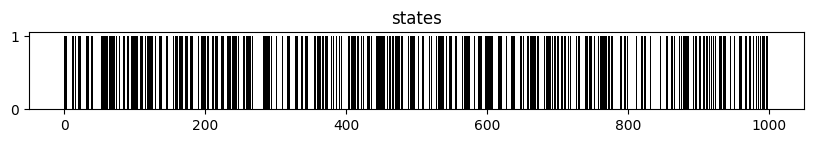

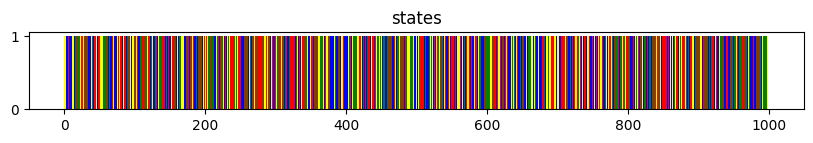

In [3]:
# Your answer goes here 
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm



#HMM:
transmat = np.array([[0.63, 0.37], 
                    [0.37, 0.63]])

start_prob = np.array([0.5, 0.5])
                    #A      C      G    T
emission_probs = ([[0.15, 0.35, 0.35, 0.15],
                   [0.40, 0.10, 0.10, 0.40]])

model = hmm.MultinomialHMM(n_components=2)
model.startprob_ = start_prob 
model.transmat_ = transmat 
model.emissionprob_ = emission_probs
model.n_trials = 1

X, Z = model.sample(1000)

#converts arrays of for [_, _, _, _] with values of all 0's and one 1 into corresponding int (0, 1, 2, 3)
samples = [i for sublist in X for i in range(len(sublist)) if sublist[i] == 1]

#Colors:
state2color = {0: 'black', 1: 'white'}
nucleobase2color = {0: 'red', 1: 'green', 2: 'yellow', 3: 'blue'}



#Plot:
def plot_DNA_samples(samples, state2color, title): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    plt.title(title)


plot_DNA_samples(Z, state2color, 'states')

plot_DNA_samples(samples, nucleobase2color, 'states')




# Question 5 (Expected) - Learning the HMM model from data 

Generate 10000 samples using the defined hmm for generating DNA sequences. Learn the HMM in an unsupervised fashion similarly to what we did with the weather example i.e only use the observation samples not the "hidden" states for estimating the model using the fit function. Constrast the original HMM to the HMM estimated from the data by comparing the transition and observation matrices. 


In [104]:
# Your answer goes here 
X, Z = model.sample(1000)

estimated_model = hmm.MultinomialHMM(n_components=2, n_iter=10000).fit(X)

print("Transition matrix")
print("Estimated model:")
print(estimated_model.transmat_)
print("Original model:")
print(model.transmat_)
print("Emission probabilities")
print("Estimated model")
print(estimated_model.emissionprob_)
print("Original model")
print(model.emissionprob_)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Transition matrix
Estimated model:
[[0.73424828 0.26575172]
 [0.82196907 0.17803093]]
Original model:
[[0.63 0.37]
 [0.37 0.63]]
Emission probabilities
Estimated model
[[0.33467935 0.25134871 0.23235635 0.18161559]
 [0.0287141  0.14749372 0.14895531 0.67483686]]
Original model
[[0.15 0.35 0.35 0.15]
 [0.4  0.1  0.1  0.4 ]]


# Question 6 (Basic) - Text categorization setup 

Text categorization is the task of assigning a given document to one of a fixed set of categories, on the basis of text it contains. Naive Bayes models are often used for this task. In these models, the query variable is the document category, and the effect variables are the presence/absence of each word in the language; the assumption is that words occur independently in documents within a given category (condititional independence), with frequencies determined by document category. Download the following file: http://www.cs.cornell.edu/People/pabo/movie-review-data/review_polarity.tar.gz containing a dataset that has been used for text mining consisting of movie reviews classified into negative and positive. You will see that there are two folders for the positivie and negative category and they each contain multiple text files with the reviews. You can find more information about the dataset at: http://www.cs.cornell.edu/People/pabo/movie-review-data/

Our goal will be to build a simple Naive Bayes classifier for this dataset. More complicated approaches using term frequency and inverse document frequency weighting and many more words are possible but the basic concepts are the same. The goal is to understand the whole process so DO NOT use existing machine learning packages but rather build the classifier from scratch.

Our feature vector representation for each text file will be simply a binary vector that shows which of the following words are present in the text file: Awful Bad Boring Dull Effective Enjoyable Great Hilarious. For example the text file cv996 11592.txt would be represented as (0, 0, 0, 0, 1, 0, 1, 0) because it contains Effective and Great but none of the other words.

Write code that parses the text files and calculates probabilities for each dictionary word given the reivew polarity. You can use any of the code provided in the notebook on quantifying uncertainty related to text Naive Bayes Classification.

In [1]:
# Your code goes here 
import os
import numpy as np
from collections import Counter
from string import punctuation

def review_parser(folder):
    feature_vector = [0, 0, 0, 0, 0, 0, 0, 0]
    for filename in os.listdir(folder):
        if filename.endswith('.txt'):
             with open(os.path.join(folder, filename)) as f:
                word_freq = Counter([word.strip(punctuation) for line in f for word in line.split()])
                feature_vector[0] += 1 if word_freq['awful'] > 0 else 0
                feature_vector[1] += 1 if word_freq['bad'] > 0 else 0
                feature_vector[2] += 1 if word_freq['boring'] > 0 else 0
                feature_vector[3] += 1 if word_freq['dull'] > 0 else 0
                feature_vector[4] += 1 if word_freq['effective'] > 0 else 0
                feature_vector[5] += 1 if word_freq['enjoyable'] > 0 else 0
                feature_vector[6] += 1 if word_freq['great'] > 0 else 0
                feature_vector[7] += 1 if word_freq['hilarious'] > 0 else 0

    #normalize the vector
    total = np.sum(feature_vector)
    for i in range(len(feature_vector)):
        feature_vector[i] = feature_vector[i]/total

    return feature_vector
            


neg_vector = review_parser('./txt_sentoken/neg/')
pos_vector = review_parser('./txt_sentoken/pos/')

print(pos_vector)
print(neg_vector)




[0.01736745886654479, 0.23308957952468007, 0.043875685557586835, 0.02102376599634369, 0.10968921389396709, 0.08683729433272395, 0.37385740402193784, 0.11425959780621572]
[0.07739463601532567, 0.38850574712643676, 0.12950191570881225, 0.07049808429118774, 0.03524904214559387, 0.04061302681992337, 0.21915708812260537, 0.03908045977011494]


# QUESTION 7 (EXPECTED) - Text classification  

Write Python code for classifying a particular test instance (in our case movie review) following a Bernoulli Bayes approach i.e you just model the presence/absence of each word. Your code should calculate the likelihood the review is positive given the correspondng conditional probabilities for each dictionary word as well as the likelihood the review is negative given the corresponding conditional probabilities for each dictionary word. Check that your code works by providing a few example cases of prediction. Your code should be written from "scratch" and only use numpy/scipy but **NOT** machine learning libraries like scikit-learn or tensorflow or pytorch.


In [10]:
# Your code goes here 


def classifier(filepath, pos_vector, neg_vector):
    test_instance = [0, 0, 0, 0, 0, 0, 0, 0]
    if filepath.endswith('.txt'):
        with open(filepath) as f:
            word_freq = Counter([word.strip(punctuation) for line in f for word in line.split()])
            test_instance[0] += 1 if word_freq['awful'] > 0 else 0
            test_instance[1] += 1 if word_freq['bad'] > 0 else 0
            test_instance[2] += 1 if word_freq['boring'] > 0 else 0
            test_instance[3] += 1 if word_freq['dull'] > 0 else 0
            test_instance[4] += 1 if word_freq['effective'] > 0 else 0
            test_instance[5] += 1 if word_freq['enjoyable'] > 0 else 0
            test_instance[6] += 1 if word_freq['great'] > 0 else 0
            test_instance[7] += 1 if word_freq['hilarious'] > 0 else 0
    
    return np.dot(test_instance, pos_vector), np.dot(test_instance, neg_vector)

pos_prob, neg_prob = classifier('./txt_sentoken/pos/cv003_11664.txt', pos_vector=pos_vector, neg_vector=neg_vector)

print("probability ./txt_sentoken/pos/cv003_11664.txt is a positive review:", pos_prob)
print("probability ./txt_sentoken/pos/cv003_11664.txt is a negative review:", neg_prob)

print('\n')

pos_prob, neg_prob = classifier('./txt_sentoken/neg/cv008_29326.txt', pos_vector=pos_vector, neg_vector=neg_vector)

print("probability ./txt_sentoken/neg/cv008_29326.txt is a positive review:", pos_prob)
print("probability ./txt_sentoken/neg/cv008_29326.txt is a negative review:", neg_prob)

print('\n')

print('this one is armageddon, so the review has words like hilarious in a negative way, and the only mention of \'great\' is in reference to the movie jaws, so the classifier gets this one wrong')
pos_prob, neg_prob = classifier('./txt_sentoken/neg/cv070_13249.txt', pos_vector=pos_vector, neg_vector=neg_vector)

print("probability ./txt_sentoken/neg/cv070_13249.txt is a positive review:", pos_prob)
print("probability ./txt_sentoken/neg/cv070_13249.txt is a negative review:", neg_prob)


probability ./txt_sentoken/pos/cv003_11664.txt is a positive review: 0.37385740402193784
probability ./txt_sentoken/pos/cv003_11664.txt is a negative review: 0.21915708812260537


probability ./txt_sentoken/neg/cv008_29326.txt is a positive review: 0.23308957952468007
probability ./txt_sentoken/neg/cv008_29326.txt is a negative review: 0.38850574712643676


this one is armageddon, so the review has words like hilarious in a negative way, and the only mention of 'great' is in reference to the movie jaws, so the classifier gets this one wrong
probability ./txt_sentoken/neg/cv070_13249.txt is a positive review: 0.48811700182815354
probability ./txt_sentoken/neg/cv070_13249.txt is a negative review: 0.2582375478927203


# QUESTION 8 (EXPECTED) - Text classification evaluation 

Calculate the classification accuracy and confusion matrix that you would obtain using the whole data set for both training and testing. Do not use machine learning libraries like scikit-learn or tensorflow for this only the basic numpy/scipy stuff.

In [25]:
# Your code goes here 
import os
import numpy as np
from collections import Counter
from string import punctuation

def tester(folder_of_databases, pos_vector, neg_vector):
    confusion_matrix = [0, 0, 0, 0]
    pos_directory = os.path.join(folder_of_databases, 'pos')
    neg_directory = os.path.join(folder_of_databases, 'neg')

    #test both the positive and negative reviews
    for folder in (pos_directory, neg_directory):
        for filename in os.listdir(folder):
            if filename.endswith('.txt'):
                with open(os.path.join(folder, filename)) as f:
                    word_freq = Counter([word.strip(punctuation) for line in f for word in line.split()])

                    test_instance = [0, 0, 0, 0, 0, 0, 0, 0]

                    test_instance[0] += 1 if word_freq['awful'] > 0 else 0
                    test_instance[1] += 1 if word_freq['bad'] > 0 else 0
                    test_instance[2] += 1 if word_freq['boring'] > 0 else 0
                    test_instance[3] += 1 if word_freq['dull'] > 0 else 0
                    test_instance[4] += 1 if word_freq['effective'] > 0 else 0
                    test_instance[5] += 1 if word_freq['enjoyable'] > 0 else 0
                    test_instance[6] += 1 if word_freq['great'] > 0 else 0
                    test_instance[7] += 1 if word_freq['hilarious'] > 0 else 0

                    pos_prob, neg_prob = np.dot(test_instance, pos_vector), np.dot(test_instance, neg_vector)

                    if pos_prob > neg_prob:
                        if folder == pos_directory:
                            confusion_matrix[0] += 1 #TP
                        else:
                            confusion_matrix[1] += 1 #FP
                    if neg_prob > pos_prob:
                        if folder != neg_directory:
                            confusion_matrix[2] += 1 #FN
                        else:
                            confusion_matrix[3] += 1 #TN
    
    total = sum(confusion_matrix)
    
    confusion_matrix[0] = confusion_matrix[0]/total
    confusion_matrix[1] = confusion_matrix[1]/total
    confusion_matrix[2] = confusion_matrix[2]/total
    confusion_matrix[3] = confusion_matrix[3]/total

    return confusion_matrix, confusion_matrix[0] + confusion_matrix[3]

conf_matrix, accuracy = tester('./txt_sentoken', pos_vector, neg_vector)
print('Confusion Matrix:', conf_matrix, '\nClassification Accuracy:', accuracy)
            


    


Confusion Matrix: [0.31159917638984214, 0.12491420727522307, 0.17227179135209333, 0.39121482498284144] 
Classification Accuracy: 0.7028140013726836


# QUESTION 9 (ADVANCED) - Maximum Likelihood, MAP, and Bayesian Learning 

In this question you are asked to come up with a variation to an existing example from the book. 
The example was covered in the notebook about learning probabilistic models and describes 5 bags of candy of two types (lime, cherry) as 5 hypotheses. Come up with a scenario (be creative but realistic) in which each hypothesis is similarly selectected with a prior probability but instead of a discrete probability distribution of lime and cherry candies as in the original example, you use a continuous probability density function fir each hypothesis. You can use simple Normal distributions characterized by a mean and variance for each hypothesis. Your example should describe a realistic scenario i.e not just have numbers but have some kind of interpretation. 

Show in a similar fashion to how the example is described in the book how you would perform maximum likelihood estimation, maximum a posteriori estimation, and Baysian Learning given some successive samples from your model. Include a plot in your example. 


# QUESTION 10 (ADVANCED) - HMM for 2D Location Estimation 

This question is a bit more open ended, will require some creativity and extra work. Consider the following problem: during your day your cell phone collects location data in terms of x,y coordinates. You do different activities such as going to university, eating, going to the gym. These activities take place in particular locations such as Restaurant A and Restaurant B or Gym A, Gym B and each particular location can be thought of as a two-dimensional Gaussian distribution of location points (your GPS sensor has some noise and depending on 
the time you are at different parts of the corresponding building). If you consider the activity as the hidden state and the location as the observation you have a Hidden Markov Model. Because activities take place in multiple locations you can model this as a Gaussian Mixture Model (GMM). Each Gaussian will be multivariate 2D Gaussian distribution characterized by two means and and a 2 by 2 covariance matrix.

Consider a hypothetical scenario with 3 activities (eat, study, exercise) and 3 locations (GMM components) for each activity. You will need to do some reading about how GMMs work. You can come up with reasonable estimates for the associated parameters.

Basically the goal is the follow the format of the Markov Chain and HMM notebook and create appropriate visualizations using this problem.

Visualize on a 2D plane using circles the different locations and corresponding mixture components 

1. Generate a dataset using a Hidden Markov Model of the problem 
2. Visualize the dataset on a 2D plane 
3. Show how you can learn the parameters of this HMM using https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.GMMHMM